# Dunkin assessment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl

the company is interested in how the biscuits interact with tea when dunked

colleague suggests liquids are soaked up by capillary flow action. (eq)

simple model - The complex cross-linked structure of a biscuit may limit the utility of the Washburn
model.


In [2]:
def washburn(gamma,r,t,phi,eta):
    numerator = gamma*r*t*np.cos(phi)
    denominator = 2*eta
    
    L = np.sqrt(numerator / denominator)
    
    return L
    

#### Big data collection

1. gamma: the tea surface tension, in N m−1
.
2. phi: the contact angle between the biscuit and the tea surface, in rad.
3. eta: the tea dynamic viscosity, in Pa s
4. L: the distance up the biscuit that the tea was visible, in m.
5. t: the time after initial dunking that the measurement was made, in s.
6. biscuit: the type of biscuit that was dunked, which is Rich Tea, Hobnob or Digestive.


In [3]:
big_data = pd.read_csv("dunking-data.csv")
print(f"shape: {big_data.shape}")
big_data.head()

shape: (3000, 6)


,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


In [4]:
biscuits = np.unique(big_data["biscuit"])
biscuits

array(['Digestive', 'Hobnob', 'Rich Tea'], dtype=object)

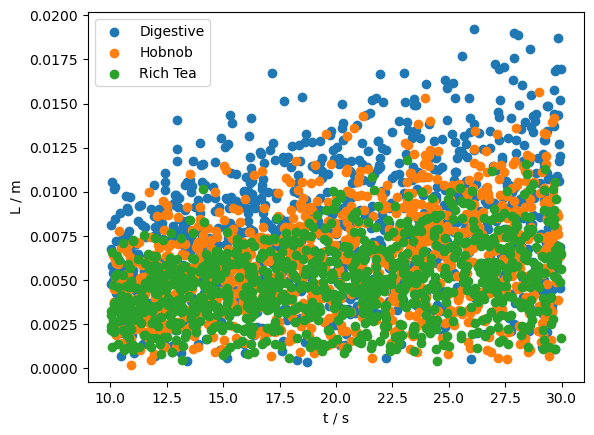

In [5]:
fig, ax = plt.subplots()

for i,biscuit in enumerate(biscuits):
    specific_big_data = big_data[big_data["biscuit"]==biscuit]
    x = specific_big_data["t"]
    y = specific_big_data["L"]
    ax.scatter(x,y, label=biscuit)
    
ax.set_xlabel("t / s")
ax.set_ylabel("L / m")
ax.legend()

# random forest???

In [6]:
# big_data['converted biscuit type'] = big_data['biscuit'].apply(lambda x: 1 if x == 'Malignant' else 0)

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(big_data, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train = scaler.fit_transform(train.drop(['biscuit'], axis=1))
scaled_test = scaler.fit_transform(test.drop(['biscuit'], axis=1))

In [9]:
train['biscuit'] = np.where([train['biscuit']=='Digestive'], 0, train['biscuit'])[0]
train['biscuit'] = np.where([train['biscuit']=='Hobnob'], 1, train['biscuit'])[0]
train['biscuit'] = np.where([train['biscuit']=='Rich Tea'], 2, train['biscuit'])[0]
train['biscuit']

642     1
700     1
226     2
1697    0
1010    1
       ..
1638    1
1095    2
1130    0
1294    0
860     2
Name: biscuit, Length: 2400, dtype: object

In [10]:
results = np.array(train['biscuit'].values, dtype=int)
results
# len(results.values)

array([1, 1, 2, ..., 0, 0, 2])

In [11]:
scaled_train.shape

(2400, 5)

In [12]:
results.shape

(2400,)

In [13]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=42, n_estimators=500, max_features=None)
RFC.fit(scaled_train, results)
prediction = RFC.predict(scaled_test)
len(prediction)

600

In [14]:
print(len(prediction[prediction == 0]))
print(len(prediction[prediction == 1]))
print(len(prediction[prediction == 2]))

206
199
195


In [15]:
test['biscuit'] = np.where([test['biscuit']=='Digestive'], 0, test['biscuit'])[0]
test['biscuit'] = np.where([test['biscuit']=='Hobnob'], 1, test['biscuit'])[0]
test['biscuit'] = np.where([test['biscuit']=='Rich Tea'], 2, test['biscuit'])[0]
test_vals = np.array(test["biscuit"].values, dtype=int)
len(test_vals)

600

In [16]:
print(len(test_vals[test_vals == 0]))
print(len(test_vals[test_vals == 1]))
print(len(test_vals[test_vals == 2]))

204
203
193


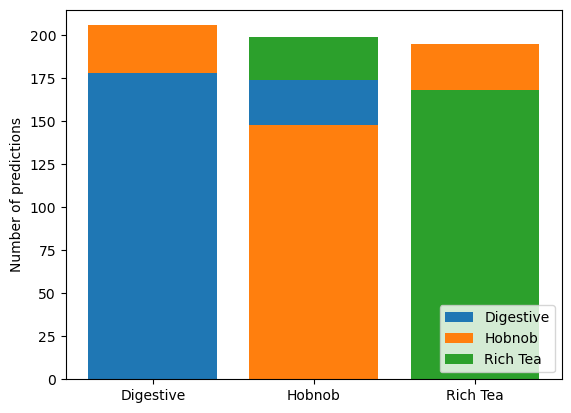

In [17]:
fig,ax = plt.subplots()

for i, biscuit in enumerate(biscuits):
    biscuit_prediction = np.where(prediction==i, True, False)

    biscuit_test = test_vals[biscuit_prediction]
    correct_predictions = len( biscuit_test[biscuit_test==i] )
    
    ax.bar(biscuit, correct_predictions, color=f"C{i}", label=biscuit)
    
    base = correct_predictions
    for j in range(len(biscuits)):
        if j != i:
            incorrect_predictions = len( biscuit_test[biscuit_test==j] )
            ax.bar(biscuit, incorrect_predictions, bottom=base, color=f"C{j}")
            base += incorrect_predictions
            
ax.set_ylabel("Number of predictions")
ax.set_ylim(0, 215)
ax.legend(loc="lower right");

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(np.array(test["biscuit"].values, dtype=int), prediction, average='weighted')
print(f'Precision: {precision:.3f}')
recall = recall_score(np.array(test["biscuit"].values, dtype=int), prediction, average='weighted')
print(f'Recall: {recall:.3f}')
f1score = f1_score(np.array(test["biscuit"].values, dtype=int), prediction, average='weighted')
print(f'F1-Score: {f1score:.3f}')
print()

Precision: 0.823
Recall: 0.823
F1-Score: 0.823



In [19]:
big_data.drop(['biscuit'],axis=1).columns

Index(['gamma', 'phi', 'eta', 'L', 't'], dtype='object')

In [20]:
importances = RFC.feature_importances_
feature_names = big_data.drop(['biscuit'],axis=1).columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_df)

  Feature  Gini Importance
3       L         0.340476
1     phi         0.283776
4       t         0.209832
0   gamma         0.112775
2     eta         0.053140


In [21]:
# use GridSearchCV
param_grid = [
  {'num_estimators': [100, 500, 1000], 'criterion': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [22]:
from sklearn.model_selection import GridSearchCV

GridSearchCV(RFC, param_grid)

GridSearchCV(estimator=RandomForestClassifier(max_features=None,
                                              n_estimators=500,
                                              random_state=42),
             param_grid=[{'criterion': ['linear'],
                          'num_estimators': [100, 500, 1000]},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}])

#### microscopy measurements

The final dataset was generated by taking a subset, one-sixth, of the dunking-data.csv samples and finding the pore radius by microscopy. This data file has similar information to the dunking-data.csv but without the biscuit type and with the pore radius. The columns, in order, are:

The final dataset is a subset of the training data.csv, where the biscuit type is no longer identified, but this has been replaced with the pore size as measured with microscopy. Therefore, this data also has six columns.

1. gamma: the tea surface tension, in N m−1
.
2. phi: the contact angle between the biscuit and the tea surface, in rad.
3. eta: the tea dynamic viscosity, in Pa s
4. L: the distance up the biscuit that the tea was visible, in m.
5. t: the time after initial dunking that the measurement was made, in s.
6. r: the radius of the pore, in m


In [23]:
microscopy_data = pd.read_csv("microscopy-data.csv")
microscopy_data.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


In [24]:
def washburn(gamma,r,t,phi,eta):
    numerator = gamma*r*t*np.cos(phi)
    denominator = 2*eta
    
    L = np.sqrt(numerator / denominator)
    
    return L

In [25]:
def predict_washburn_r(gamma,L,t,phi,eta):
    numerator = (L**2)*2*eta
    denominator = gamma*t*np.cos(phi)
    
    r = numerator / denominator
    
    return r

In [26]:
microscopy_data["L_wash"] = washburn(microscopy_data["gamma"], microscopy_data["r"], microscopy_data["t"], microscopy_data["phi"], microscopy_data["eta"])
microscopy_data["r_pred"] = predict_washburn_r(microscopy_data["gamma"], microscopy_data["L"], microscopy_data["t"], microscopy_data["phi"], microscopy_data["eta"])
# washburn(gamma,r,t,phi,eta)
microscopy_data.head()

,gamma,phi,eta,L,t,r,L_wash,r_pred
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07,0.003233,7.396247e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07,0.002436,2.513107e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07,0.003027,3.757911e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07,0.001251,7.678998e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07,0.000567,8.494983e-07


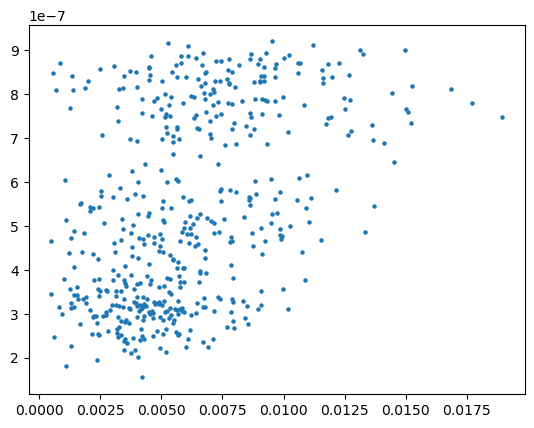

In [27]:
fig,ax=plt.subplots()

ax.scatter(microscopy_data["L_wash"], microscopy_data["r_pred"], s=5)


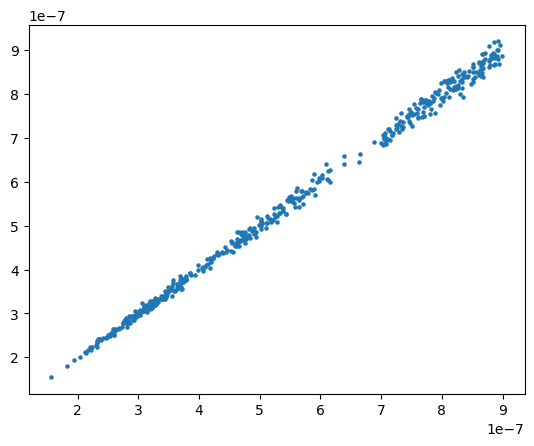

In [28]:
fig,ax=plt.subplots()
r = microscopy_data["r"]
r_pred = microscopy_data["r_pred"]
ax.scatter(r, r_pred, s=5)

In [29]:
test_micro = microscopy_data.drop(['r', 'L_wash', 'r_pred'], axis=1)
test_micro

,gamma,phi,eta,L,t
0,0.084596,1.557367,0.000981,0.003221,24.231107
1,0.064291,1.538842,0.000998,0.002395,22.169765
2,0.086224,1.546138,0.001008,0.003036,23.257709
3,0.082859,1.566878,0.000997,0.001261,12.717432
4,0.090832,1.570229,0.001002,0.000576,15.189146
...,...,...,...,...,...
495,0.077699,1.481847,0.000989,0.006078,21.967531
496,0.067776,1.488293,0.001011,0.006595,18.163634
497,0.074166,1.554817,0.000997,0.003041,18.000978
498,0.081415,1.439910,0.001011,0.009119,19.136713


In [30]:
scaled_test_micro = scaler.fit_transform(test_micro)
scaled_test_micro

array([[ 1.14599561,  1.1356957 , -1.85755021, -0.89683791,  0.77167231],
       [-0.89539042,  0.94168794, -0.27453187, -1.15666199,  0.41612889],
       [ 1.30966628,  1.01809608,  0.72485416, -0.95478295,  0.6037792 ],
       ...,
       [ 0.09739798,  1.10899036, -0.32077567, -0.953279  , -0.30290994],
       [ 0.82621258, -0.09441766,  1.04595373,  0.95980465, -0.10701664],
       [ 1.37150823,  0.79061851,  0.6782453 , -0.96069037, -1.44258582]])

In [31]:
micro_predictions = RFC.predict(scaled_test_micro)
micro_predictions


array([1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 2, 2, 1, 2, 2, 2, 0, 2, 1,
       0, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1,
       2, 1, 2, 1, 0, 2, 2, 0, 2, 0, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2,
       0, 2, 1, 1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2,
       1, 2, 2, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 2, 0, 0, 0, 0, 2, 2, 1, 2,
       1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 0, 2, 1,
       0, 2, 0, 1, 1, 2, 0, 0, 2, 1, 1, 2, 1, 2, 0, 0, 1, 0, 0, 2, 1, 2,
       1, 0, 1, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 1, 2,
       0, 0, 2, 0, 0, 2, 2, 0, 1, 1, 2, 0, 2, 1, 0, 1, 2, 2, 0, 2, 1, 1,
       0, 0, 0, 1, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2,
       2, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 0,
       0, 1, 2, 1, 2, 0, 0, 2, 1, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 1, 2,
       0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 0, 0, 1, 2, 1, 1, 0,
       1, 1, 2, 0, 2, 1, 0, 0, 1, 2, 2, 1, 2, 0, 2,

Text(0, 0.5, 'Predicted r')

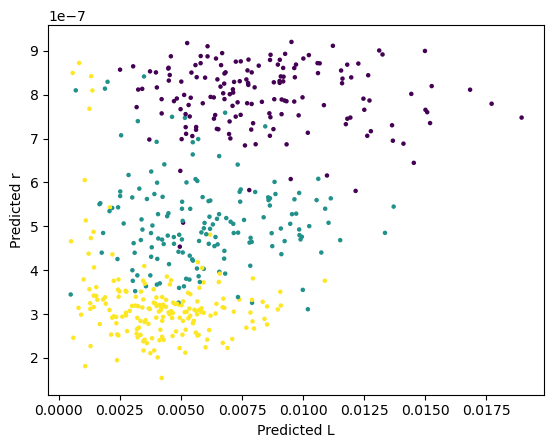

In [32]:
fig,ax=plt.subplots()

ax.scatter(microscopy_data["L_wash"], microscopy_data["r_pred"], s=5, c=micro_predictions)
ax.set_xlabel("Predicted L")
ax.set_ylabel("Predicted r")

[Text(0, 0, 'Digestive'), Text(1, 0, 'Hobnob'), Text(2, 0, 'Rich Tea')]

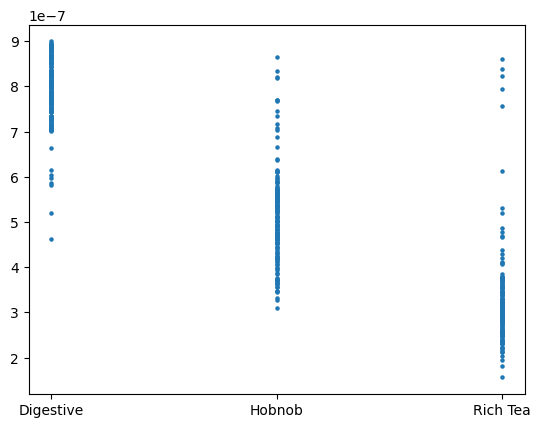

In [33]:
fig,ax=plt.subplots()

ax.scatter(micro_predictions, microscopy_data["r"], s=5)
ax.set_xticks(np.arange(0, len(biscuits)))
ax.set_xticklabels(biscuits)

In [34]:
map0 = np.where(micro_predictions==0, True, False)
microscopy_data["r"][map0]

9      8.919035e-07
12     7.250476e-07
19     7.137298e-07
22     7.894797e-07
34     7.484302e-07
           ...     
488    8.189772e-07
492    8.991764e-07
496    8.798032e-07
497    8.652230e-07
498    8.128785e-07
Name: r, Length: 160, dtype: float64

In [35]:
from scipy.stats import norm

def get_norm_distribution(data):
    mean = np.mean(data)
    std = np.std(data)
    distribution = norm.rvs(mean, std)
    return distribution.pdf()

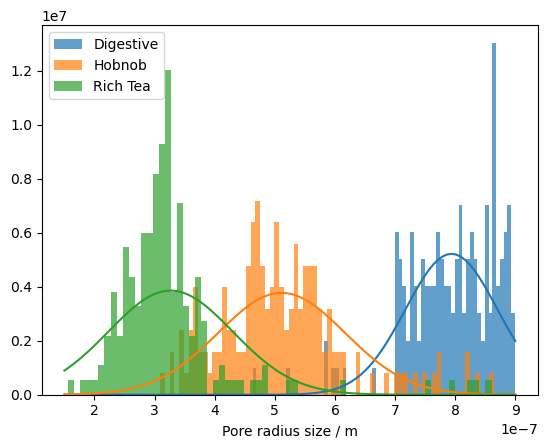

In [69]:
# plot as histogram

fig, ax = plt.subplots()

pore_radii = []

for i, biscuit in enumerate(biscuits):
    map = np.where(micro_predictions==i, True, False)
    biscuit_r_data = microscopy_data["r"][map]
    ax.hist(biscuit_r_data, bins=70, alpha=0.7, density=True, label=biscuit)
    
    mean, std = norm.fit(biscuit_r_data)
    # xmin, xmax = plt.xlim()
    x = np.linspace(1.5e-7, 9e-7, 100)
    p = (norm.pdf(x, mean, std))
    pore_radii.append(mean)
    ax.plot(x,p, color=f"C{i}")
    
ax.set_xlabel("Pore radius size / m")
ax.legend();

#### Time-resolved measurements
Another dataset has been provided, which investigates the capillary flow rate of the tea in the
biscuits. This involved taking a blind sample of each of the biscuits and measuring the length
that the tea soaked up the biscuit in a time range from 30 s to 300 s.

• the tea surface tension was measured at 6.78 × 10−2 N m−1.

• the contact angle was 1.45 rad.

• the tea dynamic viscosity was 9.93 × 10−4 Pa s.

The biscuit used for each measurement is unknown, and the data files are titled tr-1.csv, tr-2.csv, and tr-3.csv. Each data file contains the same information, three columns of experimental data:

1. t: the time elapsed in the measurement, in s, the dependent variable.
2. L: the length the tea has soaked up the biscuit, the independent variable, in m.
3. dL: an estimate of the uncertainty in length, also in m.

In [37]:
tr_1 = pd.read_csv("tr-1.csv")
tr_2 = pd.read_csv("tr-2.csv")
tr_3 = pd.read_csv("tr-3.csv")

tr_3.head()

,t,L,dL
0,30.000000,0.011187,0.000371
1,32.727273,0.011566,0.000609
2,35.454545,0.011942,0.000809
3,38.181818,0.012502,0.000614
4,40.909091,0.013343,0.000480


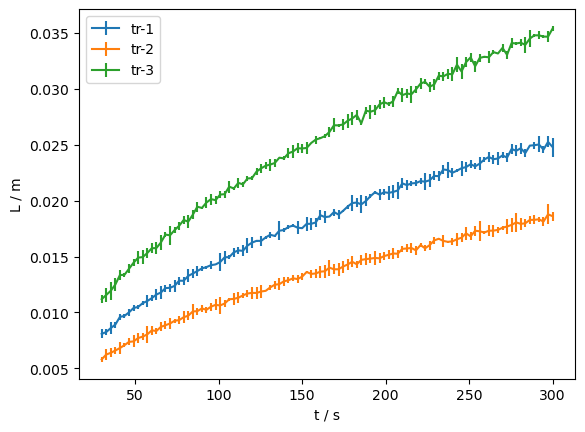

In [38]:
fig, ax = plt.subplots()

for i in range(1,4):
    data = pd.read_csv(f"tr-{i}.csv")
    x = data["t"]
    y = data["L"]
    dy = data["dL"]
    
    ax.errorbar(x,y,dy,label=f"tr-{i}")
    
ax.set_xlabel("t / s")
ax.set_ylabel("L / m")
ax.legend()

In [39]:
def washburn(gamma,r,t,phi,eta):
    """
    REDO
    A first order rate equation.
    
    :param gamma: The time to evaluate the rate equation at.
    :param r: The rate constant.
    :param t: The initial concentration of A.
    :param phi: The initial concentration of A.
    :param eta: The initial concentration of A.
    
    :return: The concentration of A at time t.
    """
    
    numerator = gamma*r*t*np.cos(phi)
    denominator = 2*eta
    
    L = np.sqrt(numerator / denominator)
    
    return L

In [ ]:
D = [norm(tr_1['L'][i], tr_1['dL'][i]) for i in range(len(tr_1))]

import pymc as pm

with pm.Model() as model:
    gamma = 6.78e-2
    r = pm.Uniform('r', 1.5e-7, 9e-7)
    phi = 1.45
    eta = 9.93e-4
    
    L = pm.Normal('t', 
                   mu=washburn(gamma,r,tr_1["t"],phi,eta), 
                   sigma=tr_1['dL'], 
                   observed=tr_1['L'])
    
    trace = pm.sample(1000, tune=1000, chains=10, progressbar=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 8 seconds.


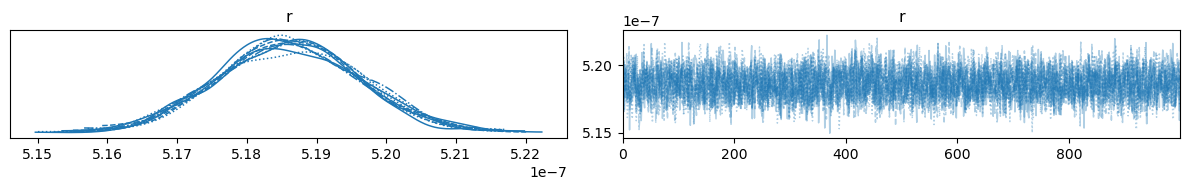

In [41]:
import matplotlib.pyplot as plt
import arviz as az

az.plot_trace(trace, var_names=["r"])
plt.tight_layout()
plt.show()

In [42]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [43]:
az.summary(trace, var_names=["r"])["mean"]

r    0.0
Name: mean, dtype: float64

In [54]:
r_mean = float(trace.posterior["r"].mean())
r_mean

5.186025002056176e-07

In [65]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az


def run_pymc(data):
    
    D = [norm(data['L'][i], data['dL'][i]) for i in range(len(data))]
    
    with pm.Model() as model:
        gamma = 6.78e-2
        r = pm.Uniform('r', 1.5e-7, 1.2e-6)
        phi = 1.45
        eta = 9.93e-4
        
        L = pm.Normal('t', 
                    mu=washburn(gamma,r,data["t"],phi,eta), 
                    sigma=data['dL'], 
                    observed=data['L'])
        
        trace = pm.sample(1000, tune=1000, chains=10, progressbar=True)
        

    az.plot_trace(trace, var_names=["r"])
    plt.tight_layout()
    plt.show()
    
    return float(trace.posterior["r"].mean())

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 5 seconds.


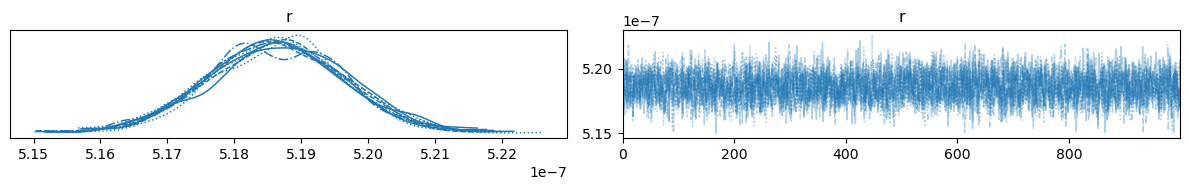

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 6 seconds.


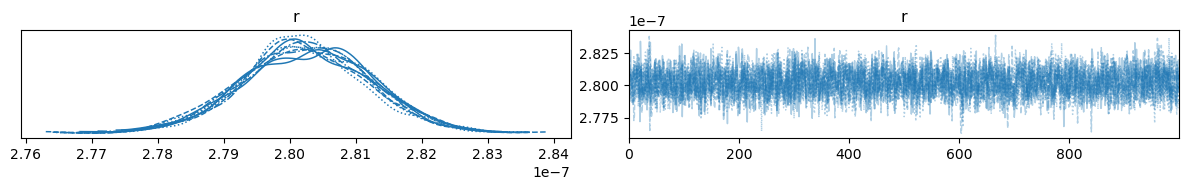

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 8 seconds.


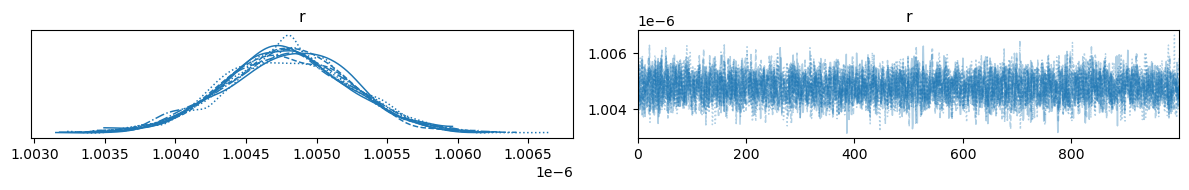

In [66]:
# fig, ax = plt.subplots()
data_r_avs = []

for i in range(1,4):
    data = pd.read_csv(f"tr-{i}.csv")
    x = data["t"]
    y = data["L"]
    dy = data["dL"]
    
    data_r = run_pymc(data)
    data_r_avs.append(data_r)


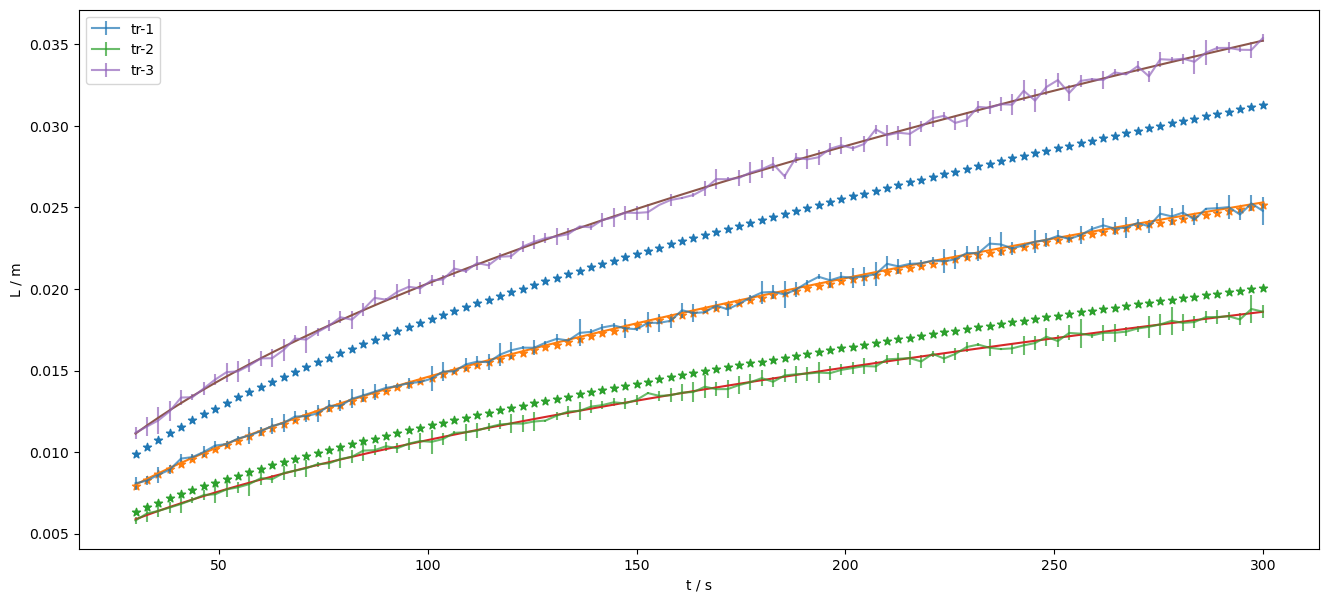

In [74]:
fig, ax = plt.subplots(figsize=(16,7))

for i in range(1,4):
    data = pd.read_csv(f"tr-{i}.csv")
    x = data["t"]
    y = data["L"]
    dy = data["dL"]
    
    
    data_r_trace = data_r_avs[i-1]
    
    washburn_data_trace = washburn(6.78e-2, data_r_trace, data["t"], 1.45, 9.93e-4 ) 
    washburn_data_rfc = washburn(6.78e-2, pore_radii[i-1], data["t"], 1.45, 9.93e-4 )
     
    ax.errorbar(x,y,dy,label=f"tr-{i}", alpha=0.7)
    ax.plot(data["t"], washburn_data_trace) 
    ax.scatter(data["t"], washburn_data_rfc, marker='*') 
    
    
ax.set_xlabel("t / s")
ax.set_ylabel("L / m")
ax.legend()
plt.show()

In [45]:
print("hi")

hi


Another dataset has been provided, which investigates the capillary flow rate of the tea in the
biscuits. This involved taking a blind sample of each of the biscuits and measuring the length
that the tea soaked up the biscuit in a time range from 30 s to 300 s.

• the tea surface tension was measured at 6.78 × 10−2 N m−1.

• the contact angle was 1.45 rad.

• the tea dynamic viscosity was 9.93 × 10−4 Pa s.

Assessment: You have been tasked with investigating the available data and outlining
the analysis that you have performed in a written report. The aim is not to do the
most analysis possible but to find a coherent story in the analysis and present
this. Some examples of questions that the team are interested in include:

• Can a machine learning algorithm be used to identify the different types of biscuits? YES, USING RFC

• How is the pore radius different between the three types of biscuits? HISTOGRAM DONE

• How accurate is the Washburn equation for biscuits, and can a machine learning
regressor perform better?

You have been asked to write a report on the available data, perform an analysis, and
outline the data results. Furthermore, highlight and describe how the team might use
these data in future data-driven investigations.